**Import Libraries**

In [60]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU before TF loads

print("✓ Training will use CPU with RAM instead of GPU")

✓ Training will use CPU with RAM instead of GPU


In [61]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
import numpy as np
tf.config.optimizer.set_jit(False)
import matplotlib.pyplot as plt
import os

**Configuration**

In [73]:
BATCH_SIZE = 2  # Very small for CPU RAM
IMAGE_SIZE = 128  # Reduced from 256 for CPU training
DOWNSCALE_FACTOR = 2
EPOCHS = 80  # Increased from 15 for better quality (CPU has RAM, no GPU memory limit)
CHANNELS = 3
# Calculate Low Resolution Size
LR_SIZE = IMAGE_SIZE // DOWNSCALE_FACTOR

**Data Preprocessing**

In [74]:
def process_input(image):
    image = image / 255.0

    img_lr = tf.image.resize(image, (LR_SIZE, LR_SIZE), method="bilinear")

    return img_lr, image # Input (LR), Target (HR)

raw_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/ritesh/Downloads/ImageSRCNN/trainning/data/train/DIV2K_HR",
    label_mode=None,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Map the processing function
train_ds = raw_dataset.map(process_input).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 800 files.


**Build the Super Resolution CNN (SRCNN)**

In [75]:
def get_sr_model():
    # Shape is (Height, Width, Channels). None allows for variable sizes.
    inputs = layers.Input(shape=(None, None, 3))
    
    # Pre-upsampling (using bilinear - GPU compatible)
    x_base = layers.UpSampling2D(size=(DOWNSCALE_FACTOR, DOWNSCALE_FACTOR), interpolation='bilinear')(inputs)
    
    # Feature extraction - more layers for better representation
    x = layers.Conv2D(64, (9, 9), activation='relu', padding='same')(x_base)
    x = layers.Conv2D(64, (7, 7), activation='relu', padding='same')(x)
    
    # Deep Non-linear mapping with skip connection (matching channels)
    x_skip = x  # Save for skip connection
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Project back to 64 channels before skip connection
    x = layers.Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    x = layers.Add()([x_skip, x])  # Now both have 64 channels
    
    # Final refinement
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Reconstruction layer
    residual = layers.Conv2D(3, (5, 5), padding='same')(x)
    
    # RESIDUAL CONNECTION: Add the upsampled input to the learned details
    outputs = layers.Add()([x_base, residual])
    outputs = layers.Activation('sigmoid')(outputs)

    model = models.Model(inputs, outputs)
    return model

model = get_sr_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, None,      │          0 │ input_layer_8[0]… │
│ (UpSampling2D)      │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, None,      │     15,616 │ up_sampling2d_8[… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, None,      │    200,768 │ conv2d_72[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, None,      │     51,232 │ conv2d_73[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, None,      │     25,632 │ conv2d_74[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_75[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_76[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, None,      │      2,112 │ conv2d_77[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, None,      │          0 │ conv2d_73[0][0],  │
│                     │ None, 64)         │            │ conv2d_78[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, None,      │     18,464 │ add_16[0][0]      │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, None,      │      2,403 │ conv2d_79[0][0]   │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, None,      │          0 │ up_sampling2d_8[… │
│                     │ None, 3)          │            │ conv2d_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, None,      │          0 │ add_17[0][0]      │
│ (Activation)        │ None, 3)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 334,723 (1.28 MB)

 Trainable params: 334,723 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [76]:
# Custom loss combining MAE + MSE for better edge preservation
def combined_loss(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.7 * mae + 0.3 * mse  # Emphasize MAE for sharpness

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=combined_loss,
    metrics=['mean_squared_error']
)

# Enhanced training with learning rate scheduling
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.7, patience=6, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = model.fit(
    train_ds,
    epochs=EPOCHS, 
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1067 - mean_squared_error: 0.0330 - learning_rate: 1.0000e-04
Epoch 2/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0630 - mean_squared_error: 0.0143 - learning_rate: 1.0000e-04
Epoch 3/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0566 - mean_squared_error: 0.0123 - learning_rate: 1.0000e-04
Epoch 4/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0534 - mean_squared_error: 0.0114 - learning_rate: 1.0000e-04
Epoch 5/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0518 - mean_squared_error: 0.0109 - learning_rate: 1.0000e-04
Epoch 6/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0507 - mean_squared_error: 0.0106 - learning_rate: 1.0000e-04
Epoch 7/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0498 - mean_squared_error: 0.0104 - learning_rate: 1.0000e-04
Epoch 8/80
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0491 - mean_squared_error: 0.0101 - learning_rate: 1.0000e-0

KeyboardInterrupt: 

**Visualization & Comparison (Results)**

In [66]:
def plot_results(model, dataset, num_samples=3):
    """
    Plots LR, Generated SR, and Ground Truth HR images side-by-side.
    Safely handles batch sizes smaller than num_samples.
    """
    # Take a single batch from the dataset
    for lr_batch, hr_batch in dataset.take(1):
        
        # --- 2. FIX FOR "slice index out of bounds" ---
        # Dynamically determine how many samples we can actually plot
        batch_size = lr_batch.shape[0]
        actual_samples = min(num_samples, batch_size)
        
        # Generate Super Resolution images for the whole batch
        # We do this outside the loop for efficiency
        sr_batch = model.predict(lr_batch)
        
        plt.figure(figsize=(15, 5 * actual_samples))
        
        for i in range(actual_samples):
            # 1. Low Resolution Image (Input)
            plt.subplot(actual_samples, 3, i * 3 + 1)
            # Use nearest neighbor to see the original "blocky" pixels
            # We resize it to IMAGE_SIZE just so the plot columns align visually
            hr_height, hr_width = hr_batch.shape[1], hr_batch.shape[2]
            display_lr = tf.image.resize(lr_batch[i], (hr_height, hr_width), method="nearest")
            plt.imshow(display_lr)
            plt.title(f"Sample {i+1}: LR Input")
            plt.axis("off")
            
            # 2. Resolved Image (Model Output)
            plt.subplot(actual_samples, 3, i * 3 + 2)
            # IMPORTANT: Model outputs can sometimes exceed [0, 1] range; clip for display
            display_sr = np.clip(sr_batch[i], 0.0, 1.0)
            plt.imshow(display_sr)
            plt.title("SR (Generated)")
            plt.axis("off")
            
            # 3. High Resolution Image (Ground Truth)
            plt.subplot(actual_samples, 3, i * 3 + 3)
            plt.imshow(hr_batch[i])
            plt.title("HR (Original)")
            plt.axis("off")
            
            # --- PSNR CALCULATION ---
            # PSNR measures the quality of the reconstruction
            psnr = tf.image.psnr(display_sr, hr_batch[i], max_val=1.0)
            print(f"Sample {i+1} PSNR: {psnr.numpy():.2f} dB")

    plt.tight_layout()
    plt.show()

In [67]:
def plot_results(lr, hr, sr):
    plt.figure(figsize=(15, 5))
    
    # Ensure SR is clipped between 0 and 1
    sr_clipped = np.clip(sr, 0.0, 1.0)
    
    images = [lr, hr, sr_clipped]
    titles = ['Low Res (Input)', 'High Res (Ground Truth)', 'Super Res (Output)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

In [68]:
try:
    plot_results(model, train_ds, num_samples=3)
except Exception as e:
    print(f"An error occurred: {e}")
    print("\nTip: If you still see 'libdevice not found', verify your CUDA path with 'whereis cuda'.")

An error occurred: plot_results() got an unexpected keyword argument 'num_samples'

Tip: If you still see 'libdevice not found', verify your CUDA path with 'whereis cuda'.


In [69]:
def predict_single_image(model, img_path):
    # 1. Load and Preprocess
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    img_array = img_array.astype('float32') / 255.0
    
    # 2. Simulate Low Res Input (Downscale it first)
    # In a real scenario, if you already have a small image, you'd just load it directly.
    # Here we downscale a high-res image to create a test case.
    original_h, original_w = img_array.shape[:2]
    lr_size = (original_h // DOWNSCALE_FACTOR, original_w // DOWNSCALE_FACTOR)
    
    img_lr = tf.image.resize(img_array, lr_size, method="bicubic")
    
    # 3. Predict (Upscale)
    # Add batch dimension (1, height, width, 3)
    input_tensor = tf.expand_dims(img_lr, axis=0) 
    sr_output = model.predict(input_tensor)
    
    # Remove batch dimension
    sr_img = np.squeeze(sr_output, axis=0)
    sr_img = np.clip(sr_img, 0.0, 1.0) # Ensure pixel values are valid
    
    return img_lr, sr_img, img_array

# Example Usage:
# test_lr, test_sr, test_hr = predict_single_image(model, "path_to_your_leaf_image.jpg")

2026-02-06 22:57:27.049914: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


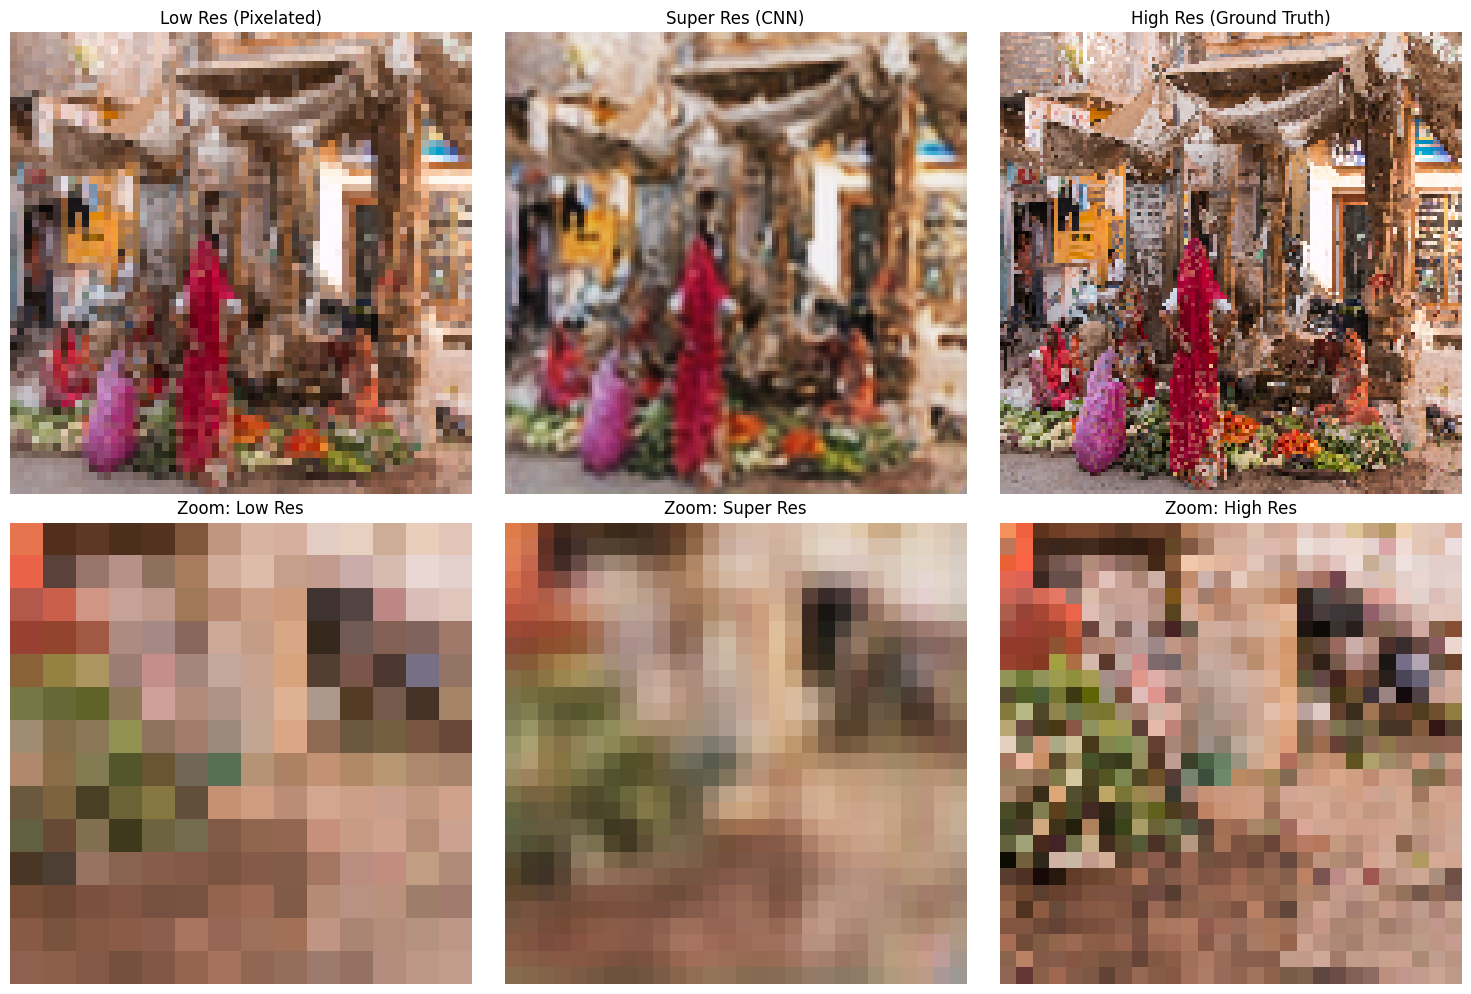

In [70]:
def plot_zoomed_comparison(lr_img, sr_img, hr_img, zoom_coords=(50, 100, 50, 100)):
    """
    zoom_coords: (y_start, y_end, x_start, x_end)
    """
    y1, y2, x1, x2 = zoom_coords
    
    # Resize LR to match HR size for display comparison
    lr_upscaled = tf.image.resize(lr_img, (hr_img.shape[0], hr_img.shape[1]), method="nearest")
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # --- Row 1: Full Images ---
    axs[0, 0].imshow(lr_upscaled)
    axs[0, 0].set_title("Low Res (Pixelated)")
    
    axs[0, 1].imshow(sr_img)
    axs[0, 1].set_title("Super Res (CNN)")
    
    axs[0, 2].imshow(hr_img)
    axs[0, 2].set_title("High Res (Ground Truth)")
    
    # --- Row 2: Zoomed Patches ---
    # Crop the regions
    lr_crop = lr_upscaled[y1:y2, x1:x2]
    sr_crop = sr_img[y1:y2, x1:x2]
    hr_crop = hr_img[y1:y2, x1:x2]
    
    axs[1, 0].imshow(lr_crop)
    axs[1, 0].set_title("Zoom: Low Res")
    
    axs[1, 1].imshow(sr_crop)
    axs[1, 1].set_title("Zoom: Super Res")
    
    axs[1, 2].imshow(hr_crop)
    axs[1, 2].set_title("Zoom: High Res")
    
    for ax in axs.flat:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example: Run on a test batch from your dataset
for lr_batch, hr_batch in train_ds.take(1):
    sr_batch = model.predict(lr_batch)
    
    # Pick the first image in the batch
    lr_sample = lr_batch[0]
    hr_sample = hr_batch[0]
    sr_sample = sr_batch[0]
    
    # Define a zoom area (adjust these coordinates based on your image size)
    # For a 256x256 image, maybe look at the center
    plot_zoomed_comparison(lr_sample, sr_sample, hr_sample, zoom_coords=(100, 150, 100, 150))
    break

In [71]:
def calculate_metrics(hr_img, sr_img):
    # PSNR
    psnr = tf.image.psnr(sr_img, hr_img, max_val=1.0).numpy()
    
    # SSIM (Structural Similarity Index)
    # Ensure images are 4D tensor for TF implementation: (1, H, W, C)
    hr_tensor = tf.expand_dims(hr_img, 0)
    sr_tensor = tf.expand_dims(sr_img, 0)
    
    ssim = tf.image.ssim(sr_tensor, hr_tensor, max_val=1.0).numpy()[0]
    
    return psnr, ssim

# Calculate for the sample we just plotted
psnr_val, ssim_val = calculate_metrics(hr_sample, sr_sample)
print(f"Quality Metrics --> PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")

Quality Metrics --> PSNR: 19.19 dB, SSIM: 0.6460


In [72]:
# Save in Keras format
model.save('super_resolution_cnn.keras')
print("Model saved successfully as super_resolution_cnn.keras")

# To load it back later:
# loaded_model = models.load_model('super_resolution_cnn.keras')

Model saved successfully as super_resolution_cnn.keras


In [ ]:
# Continue training for more epochs to improve quality
print("Continuing training with current model...")
print("This will further improve PSNR and SSIM metrics")

# Train for additional epochs
history_2 = model.fit(
    train_ds,
    epochs=50,  # Continue for 50 more epochs
    verbose=1,
    callbacks=[reduce_lr, early_stop],
    initial_epoch=history.epoch[-1] if hasattr(history, 'epoch') else 0
)

print("Additional training complete!")